# Эксперимент по модернизации данных

**Просматривая датасет, становится очевидно, что эмоции рассортированы по папкам некорректно. Есть большая доля фото, которые очевидным образом не соответствуют папке с эмоцией, в которой они находятся. То есть в данных огромное количество шума, который не позволяет улучшить точность модели. В данном ноутбуке мы выдвигаем следующую гипотезу:**

## В данных есть папка "UNCERTAIN", в которую помещались все фото, не подходящие ни под одну из предложенных восьми эмоций. Соответственно в эту папку помещаются совершенно различные эмоции, и сеть не может подстроиться к этой папке и аппроксимировать что-то одно. Так давайте исключим эту папку из обучения. Будем обучаться на "чистых" эмоциях. А затем сделаем прогноз на контрольном датасете и все эмоции, максимальная вероятность которых окажется ниже определенного нами порога, и будем скидывать в папку "UNCERTAIN". Заодно поэкспериментируем с этим самым порогом и вычислим его значение, приводящее к наилучшим результатам на kaggle.

**Загружаем библиотеки**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from livelossplot.tf_keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
import time
import numpy as np
from PIL import Image
import tensorflow_addons as tfa

2023-04-22 23:35:51.425581: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Загрузим датасет**

In [2]:
df = pd.read_csv('train.csv', index_col = 0)
df.head()

,image_path,emotion
0,./train/anger/0.jpg,anger
1,./train/anger/1.jpg,anger
2,./train/anger/10.jpg,anger
3,./train/anger/100.jpg,anger
4,./train/anger/1000.jpg,anger


**Создадим новый датафрейм df_part, исключив из исходного все строки, относящиеся к uncertain.**

In [3]:
df['image_path'] = df['image_path'].apply(lambda x: os.path.join(*x.split(sep = '/')))
df_part = df[df['emotion'] != 'uncertain']

**Разделим его на тренировочный и валидационный**

In [4]:
train_df = df_part.groupby('emotion', group_keys= False).apply(lambda x: x. sample (frac = 0.8, random_state=17))
val_df = df_part.drop(train_df.index)

**Создадим датафрейм test_df с данными, для которых надо будет сделать прогноз для kaggle.**

In [5]:
photos_list = []
for i in range(5000):
    photos_list.append(os.path.join(os.getcwd(), 'test_kaggle', str(i) + '.jpg'))
test_df = pd.DataFrame(photos_list, columns = ['image_path'])
test_df.head()

,image_path
0,/home/michael/TFODCourse/Diplom/test_kaggle/0.jpg
1,/home/michael/TFODCourse/Diplom/test_kaggle/1.jpg
2,/home/michael/TFODCourse/Diplom/test_kaggle/2.jpg
3,/home/michael/TFODCourse/Diplom/test_kaggle/3.jpg
4,/home/michael/TFODCourse/Diplom/test_kaggle/4.jpg


In [6]:
names = {0: "anger", 1: "contempt", 2: "disgust", 3: "fear",
             4: "happy", 5: "neutral", 6: "sad", 7: "surprise", 8: "uncertain"}

**Инициализируем необходимые нам функции.**

In [7]:
def make_data_generator(generator_type, df, img_size, batch_size, resc = None, prep = None, mode = 'sparse'):
    if generator_type == 'train':
        train_generator = ImageDataGenerator(rescale=resc,
                                     preprocessing_function=prep,
                                     rotation_range=45,
                                     horizontal_flip=True,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     channel_shift_range=50,
                                     fill_mode='nearest',
                                     brightness_range=[0.2,1.5])
        data_gen = train_generator.flow_from_dataframe(dataframe=df,
                                                     x_col='image_path',
                                                     y_col='emotion',
                                                     target_size=(img_size, img_size),
                                                     batch_size=batch_size,
                                                     class_mode=mode,
                                                     shuffle=True)
    if generator_type == 'val':
        val_generator = ImageDataGenerator(rescale=resc,
                                          preprocessing_function=prep)
        data_gen = val_generator.flow_from_dataframe(dataframe=df,
                                                 x_col='image_path',
                                                 y_col='emotion',
                                                 target_size=(img_size, img_size),
                                                 batch_size=batch_size,
                                                 class_mode=mode,
                                                 shuffle=False)
    return data_gen

In [8]:
def one_emotion_predict(model, path, img_size, norm = False, threshold = 0.5):
    test_img = Image.open(path)
    test_img = test_img.resize((img_size, img_size))
    test_img = np.array(test_img.getdata()).reshape(test_img.size[0], test_img.size[1], 3)
    if norm:
        test_img = test_img / 255
    test_img = test_img[np.newaxis, ...]
    pred = model.predict(test_img)
    if np.max(pred) < threshold:
        return 8
    else:
        return np.argmax(model.predict(test_img))

**Используем предобученную сеть, показавшую наилучшие результаты при тесте различных сетей в ноутбуке Neural network test.**

In [9]:
BATCH_SIZE = 104
IMAGE_SIZE = 224
N_CLASSES = 8

**Создаем генераторы данных. Как мы видим - классов 8, а не 9.**

In [10]:
train_data_gen = make_data_generator('train', train_df, IMAGE_SIZE, BATCH_SIZE, mode = 'categorical')
val_data_gen = make_data_generator('val', val_df, IMAGE_SIZE, BATCH_SIZE, mode = 'categorical')

Found 35295 validated image filenames belonging to 8 classes.
Found 8824 validated image filenames belonging to 8 classes.


In [17]:
train_data_gen.class_indices

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7}

In [11]:
base_model = tf.keras.applications.convnext.ConvNeXtXLarge(
    model_name='convnext_xlarge',
    include_top=False,
    include_preprocessing=True,
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
    classifier_activation=None
)
base_model.trainable = False

2023-04-22 23:36:23.823757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 23:36:24.379024: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5761 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:05:00.0, compute capability: 8.6


In [12]:
transf_learn_model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(N_CLASSES, activation='softmax')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=100,
    decay_rate=0.9)
checkpoint = ModelCheckpoint(os.path.join(os.getcwd(), 'CPT', 'transf_learn_model_without_uncertain', '{epoch:02d}_checkpoint_{val_categorical_accuracy:.3f}'),
                             monitor = 'val_categorical_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_freq='epoch',
                             mode='max')
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=10)
transf_learn_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),
                      tfa.metrics.F1Score(num_classes = 8, average = 'macro', dtype=tf.float32)])

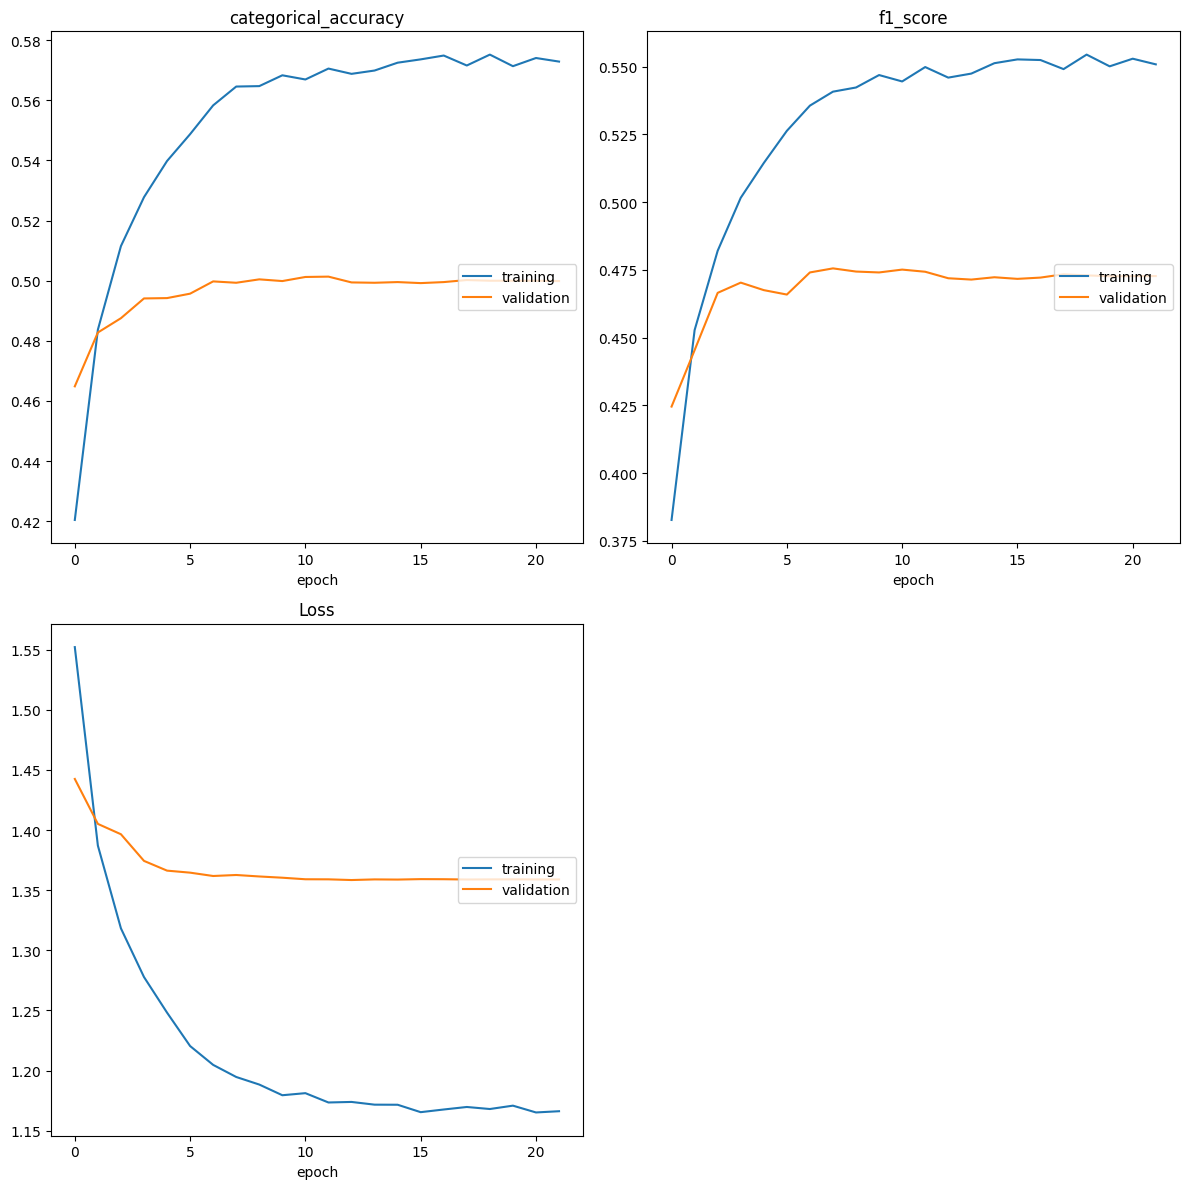

categorical_accuracy
	training         	 (min:    0.420, max:    0.575, cur:    0.573)
	validation       	 (min:    0.465, max:    0.501, cur:    0.500)
f1_score
	training         	 (min:    0.383, max:    0.554, cur:    0.551)
	validation       	 (min:    0.425, max:    0.476, cur:    0.473)
Loss
	training         	 (min:    1.165, max:    1.552, cur:    1.166)
	validation       	 (min:    1.358, max:    1.443, cur:    1.359)
340/340 [==============================] - 758s 2s/step - loss: 1.1661 - categorical_accuracy: 0.5729 - f1_score: 0.5508 - val_loss: 1.3589 - val_categorical_accuracy: 0.4999 - val_f1_score: 0.4727
Epoch 22: early stopping


In [11]:
EPOCHS = 50
history = transf_learn_model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[es, checkpoint, PlotLossesCallback()])

**Загружаем лучшее сохранение из чекпойнта. Вроде бы точность стала повыше по сравнению с той же моделью, обученной с учетом папки "UNCERTAIN" - 0.501. Но давайте проверим, что будет на kaggle.**

In [22]:
transf_learn_model = load_model(os.path.join(os.getcwd(),'CPT', 'transf_learn_model_without_uncertain', '12_checkpoint_0.501'))

**Формируем датафрейм для отправки на kaggle. Сделаем это четыре раза, используя разные значения порога, о котором упоминалось выше. А именно - 0.4, 0.3, 0.2 и 0.15**

**Почему нельзя брать порог меньше грубо говоря 0.15? Итак, наша сеть выдает список вероятностей той или иной эмоции из восьми элементов по числу эмоций. В сумме они дают единицу. Эмоция определяется по максимальной вероятности из этого списка. Значит эта вероятность должна быть больше 1 / 8 = 0.125. То есть, если вероятность будет 0.125, то эмоцию не определить - все эмоции будут равновероятны. При пороге 0.15 все эмоции, вероятность которых (максимальная из списка - выхода сети) лежит от 0.125 до 0.15 будут скинуты в папку "UNCERTAIN". Для 0.4 - все эмоции с вероятностью от 0.125 до 0.4. И так далее по тому же принципу.**

In [27]:
answer_df = pd.read_csv('sample_submission.csv')
answer_df['emotion'] = test_df['image_path'].apply(lambda x: one_emotion_predict(transf_learn_model,
                                                                                 x,
                                                                                 IMAGE_SIZE,
                                                                                 threshold = 0.15))
answer_df['emotion'] = answer_df['emotion'].apply(lambda x: names[x])

1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 57ms/step


In [28]:
answer_df.to_csv('answer2_v2.csv', index = False)

**Получаем следующие результаты на private kaggle:**

**При пороге 0.4 результат на kaggle 0.358**

**При пороге 0.3 результат на kaggle 0.4396**

**При пороге 0.2 результат на kaggle 0.442**

**При пороге 0.15 результат на kaggle 0.4424**

## Вывод: 

**1. Во-первых видно, что чем меньше мы скидываем в папку uncertain, тем лучше становится точность. Это говорит о том, что данная папка сильно влияет на общую точность сети.**

**2. Во-вторых, наилучшая метрика при минимально возможном пороге всё равно хуже, чем полученная при обучении сети на полном датасете. Значит, данный эксперимент не увенчался успехом.**

**Давайте проверим на всякий случай еще вариант со вторыми по точности результатами по итогам теста сетей из ноутбука Neyral network test - а именно fine tuning этой же сети.**

In [9]:
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  295


In [10]:
fine_tune_at = 288
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [11]:
for i in range(fine_tune_at - 4, len(base_model.layers)):
    print(f'Слой {base_model.layers[i].name}, trainable = {base_model.layers[i].trainable}')

Слой convnext_xlarge_stage_3_block_1_identity, trainable = False
Слой tf.__operators__.add_34, trainable = False
Слой convnext_xlarge_stage_3_block_2_depthwise_conv, trainable = False
Слой convnext_xlarge_stage_3_block_2_layernorm, trainable = False
Слой convnext_xlarge_stage_3_block_2_pointwise_conv_1, trainable = True
Слой convnext_xlarge_stage_3_block_2_gelu, trainable = True
Слой convnext_xlarge_stage_3_block_2_pointwise_conv_2, trainable = True
Слой convnext_xlarge_stage_3_block_2_layer_scale, trainable = True
Слой convnext_xlarge_stage_3_block_2_identity, trainable = True
Слой tf.__operators__.add_35, trainable = True
Слой layer_normalization, trainable = True


In [12]:
fine_tune_model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(N_CLASSES, activation='softmax')
])

In [13]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=100,
    decay_rate=0.98)
checkpoint = ModelCheckpoint(os.path.join(os.getcwd(), 'CPT', 'fine_tune_model_without_uncertain', '{epoch:02d}_checkpoint_{val_categorical_accuracy:.3f}'),
                             monitor = 'val_categorical_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_freq='epoch',
                             mode='max')
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=10)
fine_tune_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),
                      tfa.metrics.F1Score(num_classes = 8, average = 'macro', dtype=tf.float32)])

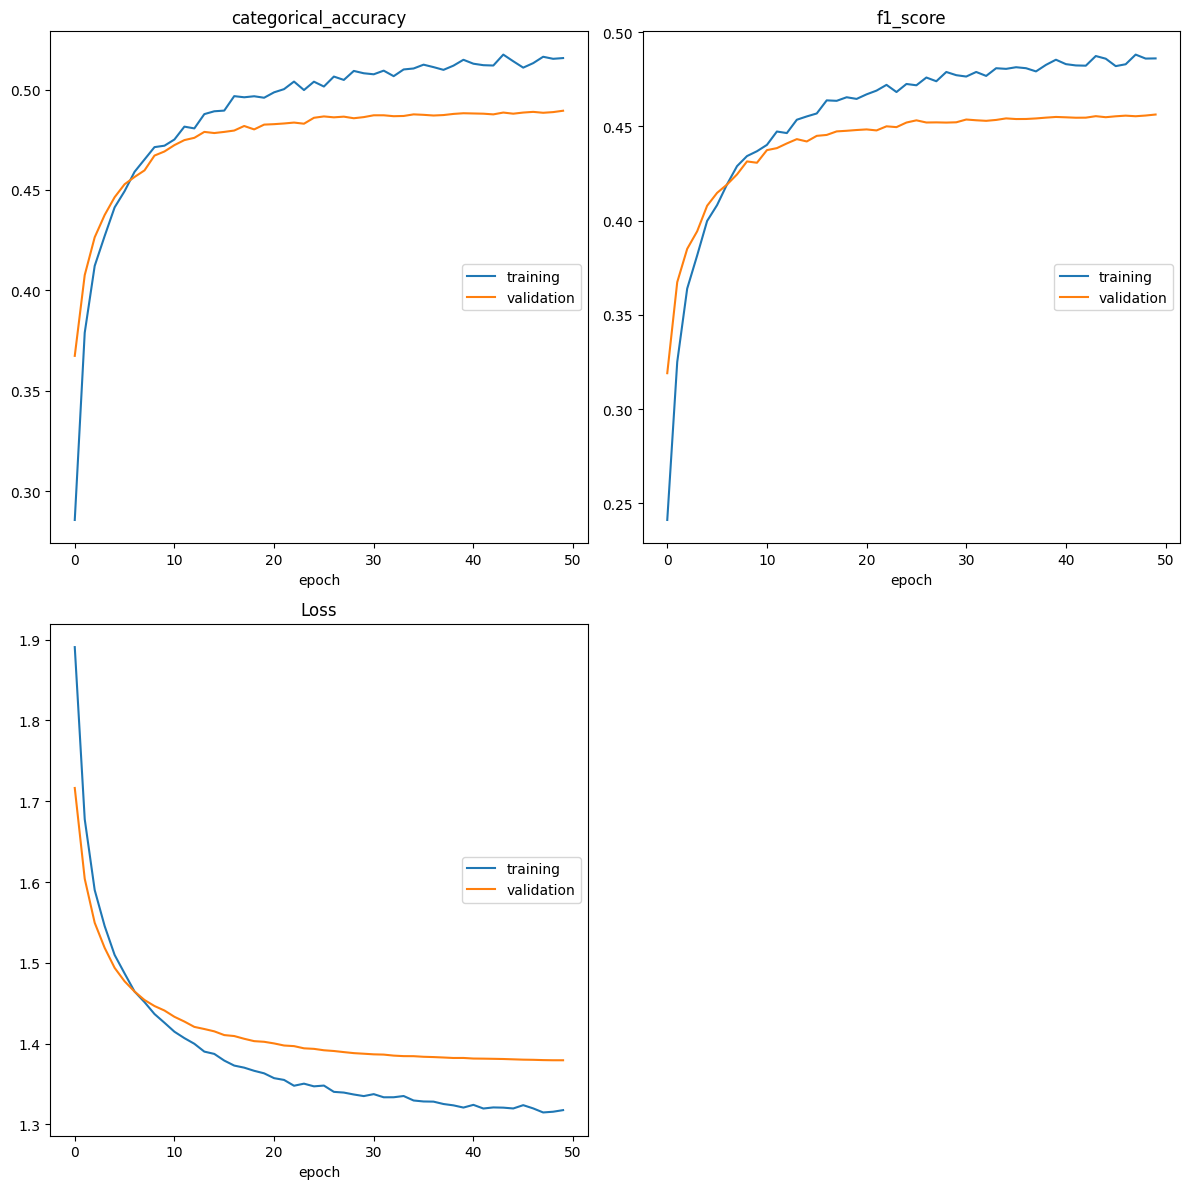

categorical_accuracy
	training         	 (min:    0.286, max:    0.517, cur:    0.516)
	validation       	 (min:    0.367, max:    0.489, cur:    0.489)
f1_score
	training         	 (min:    0.241, max:    0.488, cur:    0.486)
	validation       	 (min:    0.319, max:    0.456, cur:    0.456)
Loss
	training         	 (min:    1.315, max:    1.891, cur:    1.318)
	validation       	 (min:    1.379, max:    1.716, cur:    1.379)
340/340 [==============================] - 799s 2s/step - loss: 1.3176 - categorical_accuracy: 0.5157 - f1_score: 0.4861 - val_loss: 1.3793 - val_categorical_accuracy: 0.4895 - val_f1_score: 0.4563


In [14]:
EPOCHS = 50
history = fine_tune_model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[es, checkpoint, PlotLossesCallback()])

In [ ]:
fine_tune_model = load_model(os.path.join(os.getcwd(),'CPT', 'fine_tune_model_without_uncertain', '50_checkpoint_0.489'))

In [33]:
answer_df = pd.read_csv('sample_submission.csv')
answer_df['emotion'] = test_df['image_path'].apply(lambda x: one_emotion_predict(fine_tune_model, x, IMAGE_SIZE, threshold = 0.15))
answer_df['emotion'] = answer_df['emotion'].apply(lambda x: names[x])

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 51ms/step


In [34]:
answer_df.head()

,image_path,emotion
0,0.jpg,sad
1,1.jpg,neutral
2,2.jpg,sad
3,3.jpg,anger
4,4.jpg,contempt


In [35]:
answer_df.to_csv('answer3_v2.csv', index = False)

**Аналогично получаем следующие результаты на private kaggle:**

**При пороге 0.4 результат на kaggle 0.3316**

**При пороге 0.3 результат на kaggle 0.4196**

**При пороге 0.2 результат на kaggle 0.428**

**При пороге 0.15 результат на kaggle 0.4272**

# Общий вывод:

**Гипотеза неверна для данного случая данных, но верна по сути. О чем я? Если бы данные на private kaggle не были бы так же "зашумлены", как и на тренировочном датасете, то она должна была бы сработать. Но мы в этом еще убедимся далее.**